# Power analysis of TF capacity

For not every TF do we detect the same amount of cells. Moreover, the dose levels that each TF reaches differ by several order of magnitudes. This can lead to differences in interpretation, particularly when classifying cells as being high- or low capacity. A TF may be classified as low capacity simply because it does not reach a high-enough dose. To investigate this, we perform a power analysis to determine the minimum dose required to detect a TF as high capacity. We use TFs with high dose levels as reference, and reduce their maximal dose levels to simulate how their capacity classification would change with lower doses.

We use this to ultimately calculate the sensitivity of classifying TFs correctly as low capacity. The cutoff if minimal dose was set at 3.8 to align with a power of approx. 80%.

In [1]:
suppressPackageStartupMessages({
  suppressMessages({
    suppressWarnings({
        library(dplyr, quietly = TRUE)
        library(Seurat, quietly = TRUE)
        library(readr, quietly = TRUE)
        library(ggplot2, quietly = TRUE)
        library("org.Mm.eg.db", quietly = TRUE)

        library(Seurat)
        library(ggplot2)
        library(cowplot)
        library(tidyverse)
        library(dplyr)
        # convert symbols to ensembl ids
        convert_to_ensembl <- function(symbols) {
            ensembl_ids <- mapIds(org.Mm.eg.db, keys = symbols, keytype = "SYMBOL", column = "ENSEMBL")
            return(ensembl_ids)
        }
        convert_to_symbol <- function(ensembl_ids) {
            symbols <- mapIds(org.Mm.eg.db, keys = ensembl_ids, keytype = "ENSEMBL", column = "SYMBOL")
            return(symbols)
        }
        library(purrr)

        plots_folder <- path.expand("plots")
        if (!dir.exists(plots_folder)) {
            dir.create(plots_folder, recursive = TRUE)
        }
    })
  })
})

In [2]:
data_folder <- path.expand("../../data")

In [3]:
seu <- read_rds(file.path(data_folder, "C3H10_10X_all_exps_D0regressed10pc_50pc_integrated_dosealigned.rds"))

In [4]:
df <- read_rds(file.path(data_folder, "df_allG1Cells_PhaseCorrected_allTFs_D0regressed10pc_50pc_integrated.rds"))

In [17]:
mod.nls.nostart <- function(data, TFoi){
  mod.nls <- nls(Overall_transcriptomic_change ~ SSlogis(Dose,  Asym, xmid, scal), 
                 data = data, trace = F)
  return(mod.nls)
}

mod.nls.start.range <- function(data, TFoi, init, upper.value, lower.value){
  mod.nls <- nls(Overall_transcriptomic_change ~ SSlogis(Dose,  Asym, xmid, scal), 
                 data = data,
                #  data = subset(df, TF == TFoi),
                 start = init,
                 upper = upper.value,
                 lower = lower.value,
                 algorithm = "port", trace = F)
  return(mod.nls)
}

In [18]:
colnames(df)
colnames(df)[4] <- "Dose_unaligned"
df$Dose <- seu$Dose_aligned[rownames(df)]
df$TF[df$TF %in% c("D0","D0_confluent")] <- "D0"
df$Dose_unaligned[df$TF %in% c("D0")] <- 0
df$cell_barcode <- rownames(df)
df$TF <- as.character(df$TF)
df$batch <- seu$batch_overall[rownames(df)]

[1] "TF"                            "correlation"                  
 [3] "VectorUMI"                     "Dose_unaligned"               
 [5] "Activity"                      "Activity_TF_to_D0"            
 [7] "Dose"                          "cell_barcode"                 
 [9] "batch"                         "Overall_transcriptomic_change"

In [19]:
df <- subset(df, !TF %in% c("Mycn-Runx2","Mycn-Myog","Pparg-Runx2",
                            "Cebpa-Pparg","Cebpa-Myog","Cebpa-Mycn",
                            "Mycn-Pparg",
                            "Myo_ref",
                            "Adipo_ref",
                            "D0"
))

length(table(df$TF)) # 384
length(table(df$TF)) # 437
all_TFs <- names(table(df$TF))

[1] 384

[1] 384

In [20]:
df$Overall_transcriptomic_change <- df$Activity_TF_to_D0

In [21]:
# 4) run logistic model
df <- df[order(df$Dose),]
TFois <- unique(df$TF) # 268
model_list <- list()
plot_list <- list()
NotApplic <- c()

for (i in seq_along(TFois)){ 
  df.tfoi <- df[df$TF == TFois[i],]
  Init <- list(Asym = median(df.tfoi$Overall_transcriptomic_change), xmid = median(df.tfoi$Dose), scal = 0.1)
  Upper.value <- list(Asym = max(df.tfoi$Overall_transcriptomic_change), xmid = max(df.tfoi$Dose), scal = 10)
  Lower.value <- list(Asym = min(df.tfoi$Overall_transcriptomic_change), xmid = 0, scal = 0.001)
  model_i <- try(mod.nls.start.range(df.tfoi, TFois[i], Init, Upper.value, Lower.value),silent = TRUE)
  # check if the model was successful
  if(inherits(model_i, "try-error")){
    model_list[[i]] <- FALSE
    plot_list[[i]] <- NULL
    NotApplic <- c(NotApplic, TFois[i])
  } else {
    model_list[[i]] <- model_i
  }
}
names(model_list) <- TFois

In [23]:
#  not applicable to run self-start logistic model
TFs.notapplic  <- model_list[sapply(model_list, isFALSE)] %>% names()
# lapply(TFs.notapplic, function(x){plot.TF.activities(x, df)}) 

# rerun model for TFs with new init scal -> 1
model_list_2 <- list()
NotApplic_2 <- c()
for (i in seq_along(TFs.notapplic)){
  df.tfoi <- df[df$TF == TFs.notapplic[i],]
  Init <- list(Asym = median(df.tfoi$Overall_transcriptomic_change), xmid = median(df.tfoi$Dose), scal = 1)
  Upper.value <- list(Asym = max(df.tfoi$Overall_transcriptomic_change), xmid = max(df.tfoi$Dose), scal = 10)
  Lower.value <- list(Asym = min(df.tfoi$Overall_transcriptomic_change), xmid = 0, scal = 0.001)
  model_i <- try(mod.nls.start.range(df.tfoi, TFs.notapplic[i], Init, Upper.value, Lower.value), silent = TRUE)
  # check if the model was successful
  if(inherits(model_i, "try-error")){
    model_list_2[[i]] <- FALSE
    NotApplic_2 <- c(NotApplic_2, TFs.notapplic[i])
  } else {
    model_list_2[[i]] <- model_i
    
    # generate predicted values
    pred_data <- data.frame(Dose = df[df$TF == TFs.notapplic[i],]$Dose)
    pred_data$Overall_transcriptomic_change <- predict(model_i, newdata = pred_data)
  }
}
names(model_list_2) <- TFs.notapplic

In [24]:
length(NotApplic_2)
TFs.notapplic_2 <- model_list_2[sapply(model_list_2, isFALSE)] %>% names()
TFs.notapplic_2 # 36 TFs
# [1] "Zmat2"   "Toe1"    "Zfp467"  "Olig3"   "Zfp819"  "Zbed4"   "Bhlhe40" "Zbtb12"  "Myc"     "Zfp60"   "Zfp472"  "Zfp93"   "Zbtb5"  
# [14] "Zfp410"  "Zfp46"   "Zbtb9"   "Atf1"    "Rfx5"    "Zscan26" "Zfp69"   "Zfp335"  "Cebpe"   "Barx1"   "Zfp687"  "Lzts1"   "Zfp809" 
# [27] "Zdhhc14" "Zc2hc1a" "Zfp14"   "Rbm10"   "Zdhhc9"  "Rbm22"   "Zfp414"  "Hoxb2"   "Zbtb48"  "Hey2"

[1] 70

[1] "Zmat2"   "Toe1"    "Tox"     "Zfp521"  "Zfp467"  "Zfp263"  "Zfp810" 
 [8] "Olig3"   "Elf4"    "Zfp819"  "Zbed4"   "Zfp867"  "Bhlhe40" "Zbtb12" 
[15] "Myc"     "Zfp60"   "Zfp655"  "Zfp472"  "Zfp93"   "Thra"    "Zfp189" 
[22] "Zfp54"   "Mafb"    "Zbtb5"   "St18"    "Zfp410"  "Zfp46"   "Zbtb9"  
[29] "Atf1"    "Gmeb2"   "Rfx5"    "Zfp791"  "Zfp69"   "Zfp335"  "Smarcc1"
[36] "Rhox11"  "Zbtb18"  "Zscan20" "Zfp85"   "Mnt"     "Cebpe"   "Barx1"  
[43] "Zfp687"  "Dmbx1"   "Mitf"    "Lzts1"   "Zfp955a" "Mbnl2"   "Zfp809" 
[50] "Zdhhc14" "Zc2hc1a" "Zfp14"   "Pogz"    "Rbm10"   "Tsc22d3" "Zdhhc9" 
[57] "Rbm22"   "Trmt1"   "Msgn1"   "Zfp414"  "Hoxb2"   "Zfp366"  "Mafg"   
[64] "Stat3"   "Zbtb48"  "Zbtb39"  "Hey2"    "Mbnl3"   "Batf3"   "Foxn1"

In [ ]:
model_list <- model_list[!sapply(model_list, isFALSE)]
model_list_2 <- model_list_2[!sapply(model_list_2, isFALSE)]


model_list.com <- c(model_list, model_list_2)
names(model_list.com) <- c(names(model_list), names(model_list_2)) # 232 TFs (= 268 - 36 TFs.notapplic_2)

In [26]:
nls.Par <- lapply(names(model_list.com), function(x){
  nls.Par.tfoi <- data.frame(round(coef(model_list.com[[x]]), 3))
  colnames(nls.Par.tfoi) <- x
  nls.Par.tfoi <- t(nls.Par.tfoi) %>% as.data.frame()
  nls.Par.tfoi$TF <- x
  nls.Par.tfoi$Dose.max <- max(df$Dose[df$TF == x]) %>% round(digits = 3)
  nls.Par.tfoi$Dose.min <- min(df$Dose[df$TF == x]) %>% round(digits = 3)
  nls.Par.tfoi$startpoint <- fitted(model_list.com[[x]])[1] %>% round(digits = 2)
  nls.Par.tfoi$endpoint <- fitted(model_list.com[[x]]) %>% tail(1) %>% round(digits = 2)
  return(nls.Par.tfoi)
})
names(nls.Par) <- names(model_list.com)
nls.Par <- data.table::rbindlist(nls.Par) %>% as.data.frame()
rownames(nls.Par) <- nls.Par$TF

In [27]:
functionality_all <- seu@meta.data |> filter(!TF %in% c("Mycn-Runx2","Mycn-Myog","Pparg-Runx2",
                            "Cebpa-Pparg","Cebpa-Myog","Cebpa-Mycn",
                            "Mycn-Pparg",
                            "Myo_ref",
                            "Adipo_ref",
                            "D0", "D0_confluent"
)) |> group_by(TF) |> summarize(max.dose = max(Dose_aligned))
functionality <- left_join(functionality_all, nls.Par)
functionality$endpoint <- ifelse(is.na(functionality$endpoint), 0., functionality$endpoint)

Joining with `by = join_by(TF)`


In [28]:
functionality$category <- "-"
functionality$category[(functionality$endpoint >= 0.23)] <- "high-capacity"
functionality$category[(functionality$endpoint < 0.23)] <- "low-capacity"

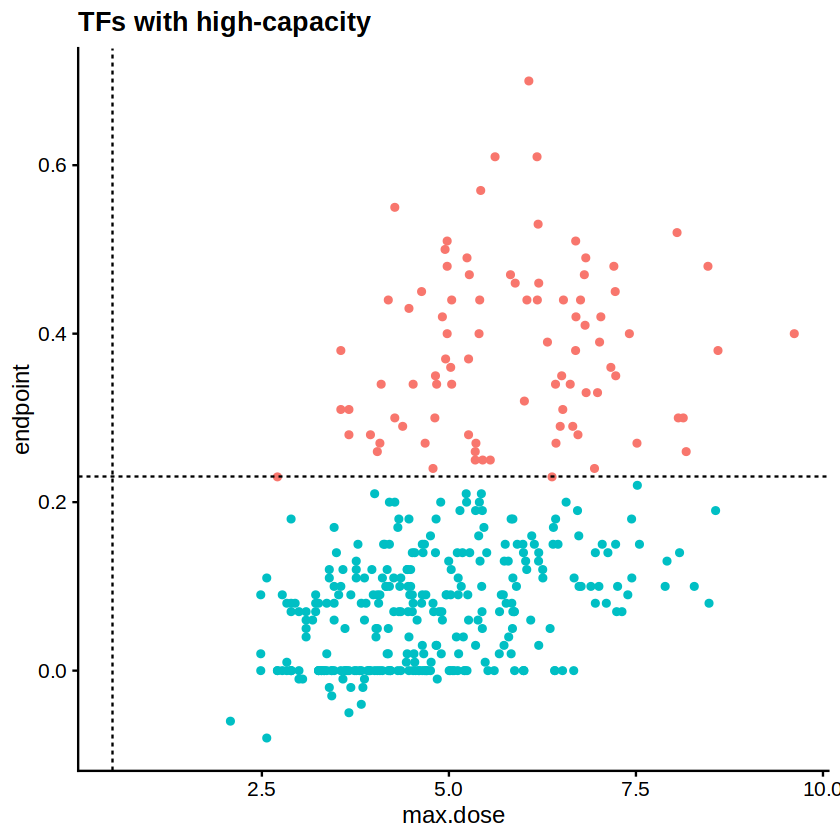

In [29]:
ggplot(functionality, aes(x = max.dose, y = endpoint, col = category)) + geom_point() + theme_cowplot() + geom_hline(yintercept = 0.23, linetype = "dashed") + geom_vline(xintercept = 0.5, linetype = "dashed") + ggtitle("TFs with high-capacity") + theme(legend.position = "none")

In [32]:
get_capacity <- function(df.tfoi, TFoi) {
  Init <- list(Asym = median(df.tfoi$Overall_transcriptomic_change), xmid = median(df.tfoi$Dose), scal = 0.1)
  Upper.value <- list(Asym = max(df.tfoi$Overall_transcriptomic_change), xmid = max(df.tfoi$Dose), scal = 10)
  Lower.value <- list(Asym = min(df.tfoi$Overall_transcriptomic_change), xmid = 0, scal = 0.001)
  model_i <- try(mod.nls.start.range(df.tfoi, TFoi, Init, Upper.value, Lower.value), silent = TRUE)
  if(inherits(model_i, "try-error")){
    Init <- list(Asym = median(df.tfoi$Overall_transcriptomic_change), xmid = median(df.tfoi$Dose), scal = 1)
    Upper.value <- list(Asym = max(df.tfoi$Overall_transcriptomic_change), xmid = max(df.tfoi$Dose), scal = 10)
    Lower.value <- list(Asym = min(df.tfoi$Overall_transcriptomic_change), xmid = 0, scal = 0.001)
    model_i <- try(mod.nls.start.range(df.tfoi, TFoi, Init, Upper.value, Lower.value), silent = TRUE)
    # check if the model was successful
    if(inherits(model_i, "try-error")){
        endpoint <- 0.
    } else {
        endpoint <- fitted(model_i) %>% tail(1) %>% round(digits = 2)
    }
  } else {
    endpoint <- fitted(model_i) %>% tail(1) %>% round(digits = 2)
  }

  return(endpoint)
}

df.tfoi <- df[df$TF == "Runx2",] |> filter(Dose <= 1.5)
print(dim(df.tfoi))
get_capacity(df.tfoi, "Runx2")

[1] 508  10


[1] 0.27

In [33]:
cutoffs <- seq(1., 10., by = 0.25)
design <- expand.grid(TF = functionality |> filter(category != "low-capacity") |> pull(TF), cutoff = cutoffs)
capacities <- design |> pmap_dfr(function(TF_oi, cutoff) {
  df.tfoi <- df[df$TF == TF_oi,] |> filter(Dose <= cutoff)
  if (nrow(df.tfoi) < 4) {
    return(tibble(cutoff = cutoff, capacity = 0, TF = TF_oi))
  }
  tibble(cutoff = cutoff, capacity = get_capacity(df.tfoi, TF_oi), TF = TF_oi)
})

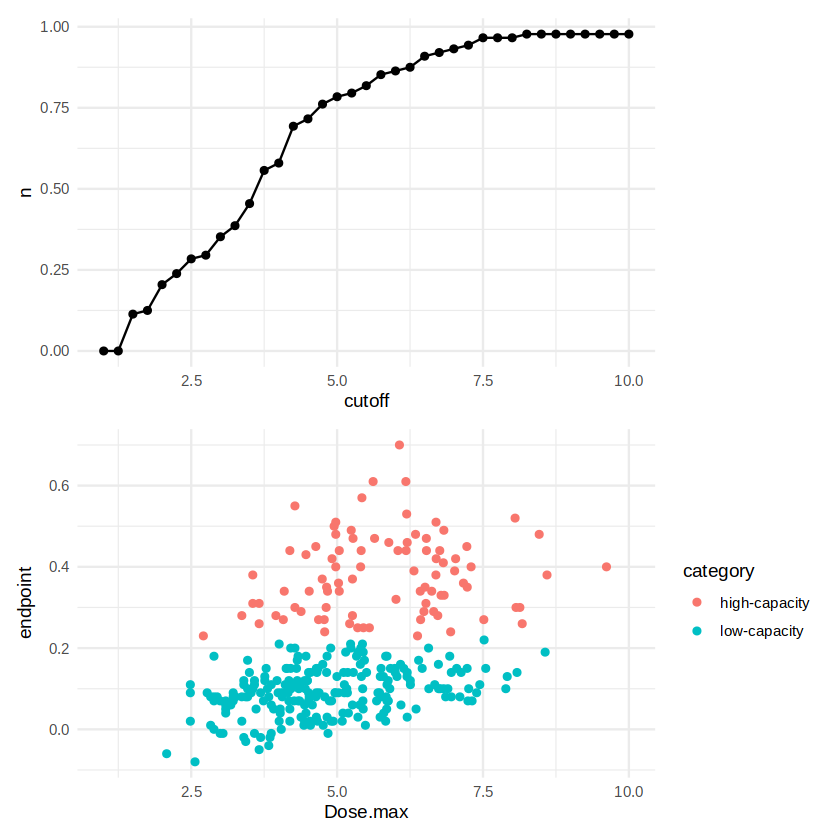

In [39]:
functionality_rates <- capacities |> group_by(cutoff) |> summarise(n = mean(capacity > 0.23))
plot_functionality_rate <- ggplot(functionality_rates, aes(x = cutoff, y = n)) + geom_line() + geom_point() + theme_minimal() + scale_x_continuous(limits = c(min(cutoffs), max(cutoffs)))
plot_dose_max <- ggplot(functionality |> filter(!is.na(Dose.max)), aes(x = Dose.max, y = endpoint, col = category)) + geom_point() + theme_minimal() + scale_x_continuous(limits = c(min(cutoffs), max(cutoffs)))
patchwork::wrap_plots(plot_functionality_rate, plot_dose_max, ncol = 1)

In [40]:
# interpolate the functionality rate for each TF
functionality$false_low_capacity_prob <- 1-approx(functionality_rates$cutoff, functionality_rates$n, xout = functionality$max.dose)$y
functionality$false_low_capacity_prob_fixed <- ifelse(
    functionality$category != "low-capacity",
    0,
    functionality$false_low_capacity_prob
)

In [41]:
colorbar <- guide_colorbar(
    ticks.colour = "#333333",                     # Tick mark color
    ticks.linewidth = 0.5,                       # Tick mark width
    frame.colour = "#333333",                     # Border color around colorbar
    frame.linewidth = 0.5
  )

Warning message:
“Removed 13 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 13 rows containing missing values or values outside the scale range
(`geom_point()`).”


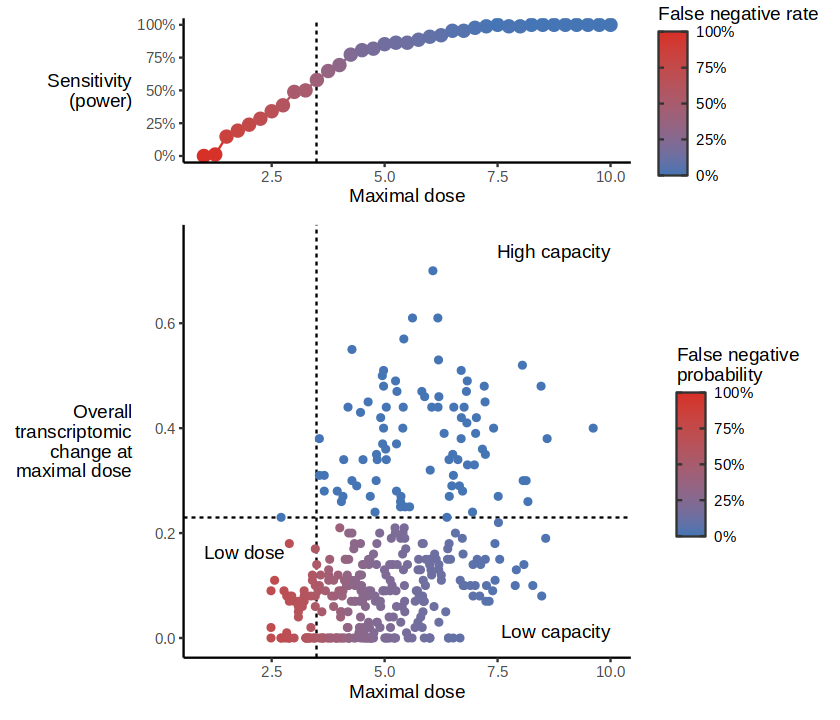

In [42]:
functionality_rates <- capacities |> group_by(cutoff) |> summarise(n = mean(capacity > 0.2))
plot_functionality_rate <- ggplot(functionality_rates, aes(x = cutoff, y = n, color = 1-n)) + 
    geom_vline(xintercept = 3.5, linetype = "dashed") + 
    geom_line() + 
    geom_point(size = 3) + 
    theme_classic() + 
    scale_x_continuous(limits = c(min(cutoffs), max(cutoffs))) + 
    scale_color_gradient(name = "False negative rate", low = "#4575b4", high = "#d73027", limits = c(0, 1.), oob = scales::squish, labels=scales::percent) + 
    ylab("Sensitivity\n(power)") + 
    xlab("Maximal dose") + 
    scale_y_continuous(limits = c(0, 1), labels=scales::percent) + 
    theme(axis.title.y = element_text(angle = 0, vjust = 0.5, hjust = 1)) +
    guides(color = colorbar)
plot_dose_max <- ggplot(functionality, aes(x = max.dose, y = endpoint, col = false_low_capacity_prob_fixed)) + 
    geom_vline(xintercept = 3.5, linetype = "dashed") + 
    geom_hline(yintercept = 0.23, linetype = "dashed") + 
    geom_point() + 
    theme_classic() + 
    scale_x_continuous(limits = c(min(cutoffs), max(cutoffs))) + 
    scale_y_continuous(limits = c(0, 0.75)) + 
    scale_color_gradient(name = "False negative\nprobability", low = "#4575b4", high = "#d73027", limits = c(0, 1.), oob = scales::squish, labels=scales::percent) + 
    ylab("Overall\ntranscriptomic\nchange at\nmaximal dose") + 
    xlab("Maximal dose") + 
    theme(axis.title.y = element_text(angle = 0, vjust = 0.5, hjust = 1)) +
    annotate("text", x = 10, y = 0.75, label = "High capacity", vjust = 1, hjust = 1) +
    annotate("text", x = 10, y = 0., label = "Low capacity", vjust = 0, hjust = 1) +
    annotate("text", x = 1.0, y = 0.15, label = "Low dose", vjust = 0, hjust = 0) +
    guides(color = colorbar)
plot <- patchwork::wrap_plots(plot_functionality_rate, plot_dose_max, ncol = 1, heights = c(1, 3))
# ggsave
options(repr.plot.width=7, repr.plot.height=6)
plot
ggsave(file.path(plots_folder, "functionality_rate_vs_dose_max.png"), plot, width = 8, height = 7)


In [43]:
functionality$max_dose_bin <- factor(cut(functionality$max.dose, breaks = seq(0, 10, by = 1.), labels = c("0-1", "1-2", "2-3", "3-4", "4-5", "5-6", "6-7", "7-8", "8-9", "9-10")), levels = c("0-1", "1-2", "2-3", "3-4", "4-5", "5-6", "6-7", "7-8", "8-9", "9-10"))
plotdata <- functionality |> filter(endpoint < 0.23, endpoint != 0)

`summarise()` has grouped output by 'max_dose_bin'. You can override using the
`.groups` argument.


Warning message:
“Removed 13 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 13 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 13 rows containing missing values or values outside the scale range
(`geom_point()`).”


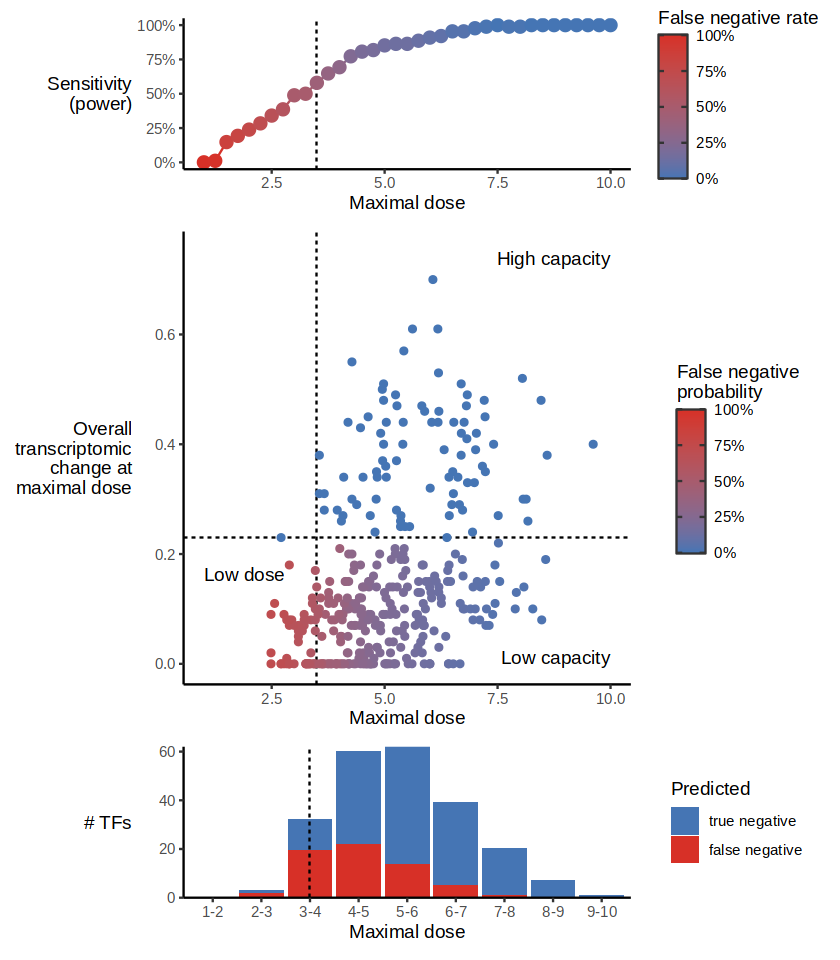

In [44]:
functionality$max_dose_bin <- factor(cut(functionality$max.dose, breaks = seq(0.5, 9.5, by = 1.), labels = c("1-2", "2-3", "3-4", "4-5", "5-6", "6-7", "7-8", "8-9", "9-10")), levels = c("1-2", "2-3", "3-4", "4-5", "5-6", "6-7", "7-8", "8-9", "9-10"))
plotdata <- functionality |> filter(endpoint < 0.23, endpoint != 0)
plotdata <- bind_rows(
    plotdata |> mutate(type = "true negative", prob = 1-false_low_capacity_prob_fixed),
    plotdata |> mutate(type = "false negative", prob = false_low_capacity_prob_fixed)
) |> group_by(max_dose_bin, type, .drop=F) |> summarize(prob = sum(prob)) |> mutate(type = ifelse(is.na(type), "true negative", type)) |> mutate(type = factor(type, levels = c("true negative", "false negative")))
plot_n <- ggplot(plotdata) + 
    geom_bar(aes(x = max_dose_bin, y = prob, fill = type), stat = "identity", width = 0.9) + 
    theme_minimal() + 
    theme(legend.position = "none") + 
    ylab("# TFs") + 
    xlab("Maximal dose") + 
    scale_y_continuous(expand = c(0, 0)) +
    scale_fill_manual(name = "Predicted", values = c(`true negative` = "#4575b4", `false negative` = "#d73027")) +
    geom_vline(xintercept = 3., linetype = "dashed") +
    theme_classic() +
    theme(axis.title.y = element_text(angle = 0, vjust = 0.5, hjust = 1))

plot <- patchwork::wrap_plots(plot_functionality_rate, plot_dose_max, plot_n, ncol = 1, heights = c(1, 3, 1))
options(repr.plot.width=7, repr.plot.height=8)
plot
ggsave(file.path(plots_folder, "functionality_rate_vs_dose_max.png"), plot, width = 8, height = 7)
ggsave(file.path(plots_folder, "functionality_rate_vs_dose_max.pdf"), plot, width = 8, height = 7)

In [25]:
functionality |> dplyr::select(TF, false_low_capacity_prob_fixed) |> write_csv(file.path(plots_folder, "false_low_capacity_prob.csv"))

Expeceted number of TFs that are to be high capacity, but are not detected as such due to low dose levels (i.e. number of false-negatives):

In [28]:
functionality |> filter(max.dose > 3.8, endpoint < 0.23, endpoint != 0) |> pull(false_low_capacity_prob_fixed) |> sum()

[1] 37.51643

Sensitivity of our analysis, using the cutoff at 3.8 is approximately 80%:

In [31]:
1-(functionality |> filter(max.dose > 3.8, endpoint < 0.23, endpoint != 0) |> pull(false_low_capacity_prob_fixed) |> mean())

[1] 0.7880428